In [ ]:
!pip install dionysus
!pip install POT
!pip install gudhi
!pip install importlib-metadata==4.13.0

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import ot
import dionysus as d
from gudhi.wasserstein import wasserstein_distance as wd
from sklearn.cluster import KMeans
from numpy import linalg as LA

/usr/local/lib/python3.10/dist-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [ ]:
from google.colab import drive
from google.colab import files
import os

drive.mount('/content/drive',force_remount=True)
os.chdir("/content/drive/My Drive/NASA/Fire Detection/Paper")
!ls -ltr

Mounted at /content/drive
total 83
-rw------- 1 root root  3365 Dec 10 23:23 'Screenshot 2023-12-10 172310.png'
-rw------- 1 root root  3207 Dec 10 23:23 'Screenshot 2023-12-10 172323.png'
-rw------- 1 root root 77269 Dec 10 23:47  pds.pdf


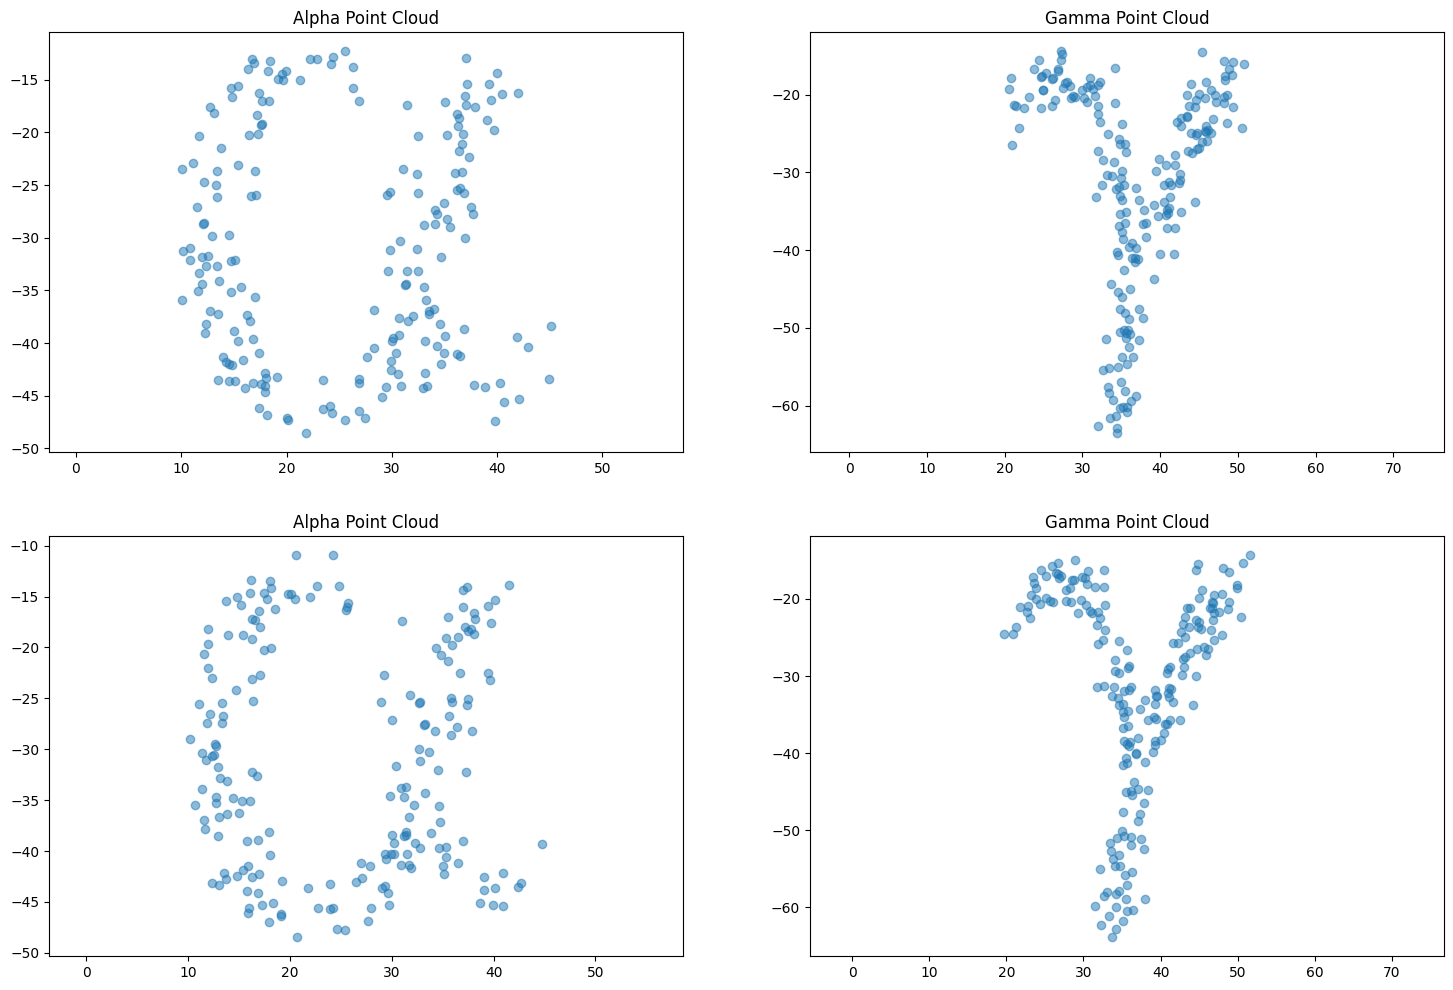

In [ ]:
def image_to_point_clouds(image_path, noise_level, n_samples, n_clouds):
    # Load the image
    image = Image.open(image_path)

    # Convert the image to black and white
    bw_image = image.convert('L').point(lambda x: 0 if x < 128 else 255, '1')

    # Extract coordinates of black pixels
    black_pixels = np.column_stack(np.where(np.array(bw_image) == 0))

    # Adjust the number of points to n_samples
    if len(black_pixels) > n_samples:
        selected_indices = np.random.choice(len(black_pixels), n_samples, replace=False)
        black_pixels = black_pixels[selected_indices]
    elif len(black_pixels) < n_samples:
        selected_indices = np.random.choice(len(black_pixels), n_samples, replace=True)
        black_pixels = black_pixels[selected_indices]

    point_clouds = []
    for _ in range(n_clouds):
        # Add noise
        noisy_points = black_pixels + noise_level * np.random.normal(size=black_pixels.shape)
        point_clouds.append(noisy_points)

    return point_clouds

# Path to the images of alpha and gamma
alpha_image_path = 'Screenshot 2023-12-10 172310.png'
gamma_image_path = 'Screenshot 2023-12-10 172323.png'

# Generate point clouds
n_samples = 200
n_clouds = 7  # Number of point clouds to generate
noise_level = 1
alpha_point_clouds = image_to_point_clouds(alpha_image_path, noise_level, n_samples, n_clouds)
gamma_point_clouds = image_to_point_clouds(gamma_image_path, noise_level, n_samples, n_clouds)

# Plotting the first point cloud of alpha and gamma for demonstration
plt.figure(figsize=(18, 12))

# Alpha
plt.subplot(2, 2, 1)
plt.scatter(alpha_point_clouds[0][:, 1], -alpha_point_clouds[0][:, 0], alpha=0.5)
plt.title('Alpha Point Cloud')
plt.axis('equal')

# Gamma
plt.subplot(2, 2, 2)
plt.scatter(gamma_point_clouds[0][:, 1], -gamma_point_clouds[0][:, 0], alpha=0.5)
plt.title('Gamma Point Cloud')
plt.axis('equal')

plt.subplot(2, 2, 3)
plt.scatter(alpha_point_clouds[1][:, 1], -alpha_point_clouds[1][:, 0], alpha=0.5)
plt.title('Alpha Point Cloud')
plt.axis('equal')

# Gamma
plt.subplot(2, 2, 4)
plt.scatter(gamma_point_clouds[1][:, 1], -gamma_point_clouds[1][:, 0], alpha=0.5)
plt.title('Gamma Point Cloud')
plt.axis('equal')
plt.show()

In [ ]:
def plot_Dionysus_PDs(pd0_array, pd1_array, titles, lower_bound=240, upper_bound=300):
    fig = plt.figure(figsize=(30,18))
    nday = len(pd0_array)
    for iday in np.arange(nday):
        ax = fig.add_subplot(2,7,1+iday)
        ax.scatter(pd0_array[iday][0], pd0_array[iday][1], color='r', s=5, label = '0')
        ax.scatter(pd1_array[iday][0], pd1_array[iday][1], marker='^', s=5, facecolors='none', edgecolor='blue', label = '1')

        ax.plot(np.arange(0, 3), np.arange(0, 3), '-', color='grey', lw=0.5)
        #ax.set_xlim([lower_bound, upper_bound])
        #ax.set_ylim([lower_bound, upper_bound])
        ax.set_title(titles[iday])
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death')
    plt.savefig("pds.pdf",bbox_inches='tight')
    plt.show()

def getPD(data, r):
    f = d.fill_rips(np.array(data, dtype='float64'), 2, r)
    p = d.homology_persistence(f)
    dgms = d.init_diagrams(p, f)
    birth0 = [dgm.birth for dgm in dgms[0]]
    death0 = [dgm.death for dgm in dgms[0]]
    birth1 = [dgm.birth for dgm in dgms[1]]
    death1 = [dgm.death for dgm in dgms[1]]
    return [[birth0,death0],[birth1,death1]]

def coordinates_to_image(x_coords, y_coords, image_size=(100, 100)):
    # Create an array of zeros with the specified image size
    image = np.zeros(image_size, dtype=int)

    # Normalize the coordinates to fit within the image size
    x_coords = ((x_coords - np.min(x_coords)) / (np.max(x_coords) - np.min(x_coords))) * (image_size[0] - 1)
    y_coords = ((y_coords - np.min(y_coords)) / (np.max(y_coords) - np.min(y_coords))) * (image_size[1] - 1)

    # Round the coordinates to the nearest integer and set corresponding pixels to 1
    x_coords = np.round(x_coords).astype(int)
    y_coords = np.round(y_coords).astype(int)
    image[y_coords, x_coords] = 1

    return image

In [ ]:
samples = alpha_point_clouds + gamma_point_clouds

In [ ]:
pd0_union = []
pd1_union = []
pd0 = []
pd1 = []

PD_dict = {}
for i in np.arange(n_clouds*2):
    print ('Working on number {}'.format(i))
    p0, p1 = getPD(samples[i], 50)

    #PD_dict['PD{}'.format(i)] = np.vstack((np.column_stack((p0[0],p0[1])), np.column_stack((p1[0],p1[1]))))
    #np.savez('/content/drive/My Drive/Coding/PD{}'.format(i), PD_dict['PD{}'.format(i)])

    PD_dict['PD{} dim0'.format(i)] = np.column_stack((p0[0],p0[1]))
    PD_dict['PD{} dim1'.format(i)] = np.column_stack((p1[0],p1[1]))
    #np.savez('/content/drive/My Drive/Coding/PD{} dim0'.format(i), PD_dict['PD{} dim0'.format(i)])
    #np.savez('/content/drive/My Drive/Coding/PD{} dim1'.format(i), PD_dict['PD{} dim1'.format(i)])

    pd0_union.append(p0)
    pd1_union.append(p1)
    pd0.append(p0)
    pd1.append(p1)

Working on number 0
Working on number 1
Working on number 2
Working on number 3
Working on number 4
Working on number 5
Working on number 6
Working on number 7
Working on number 8
Working on number 9
Working on number 10
Working on number 11
Working on number 12
Working on number 13


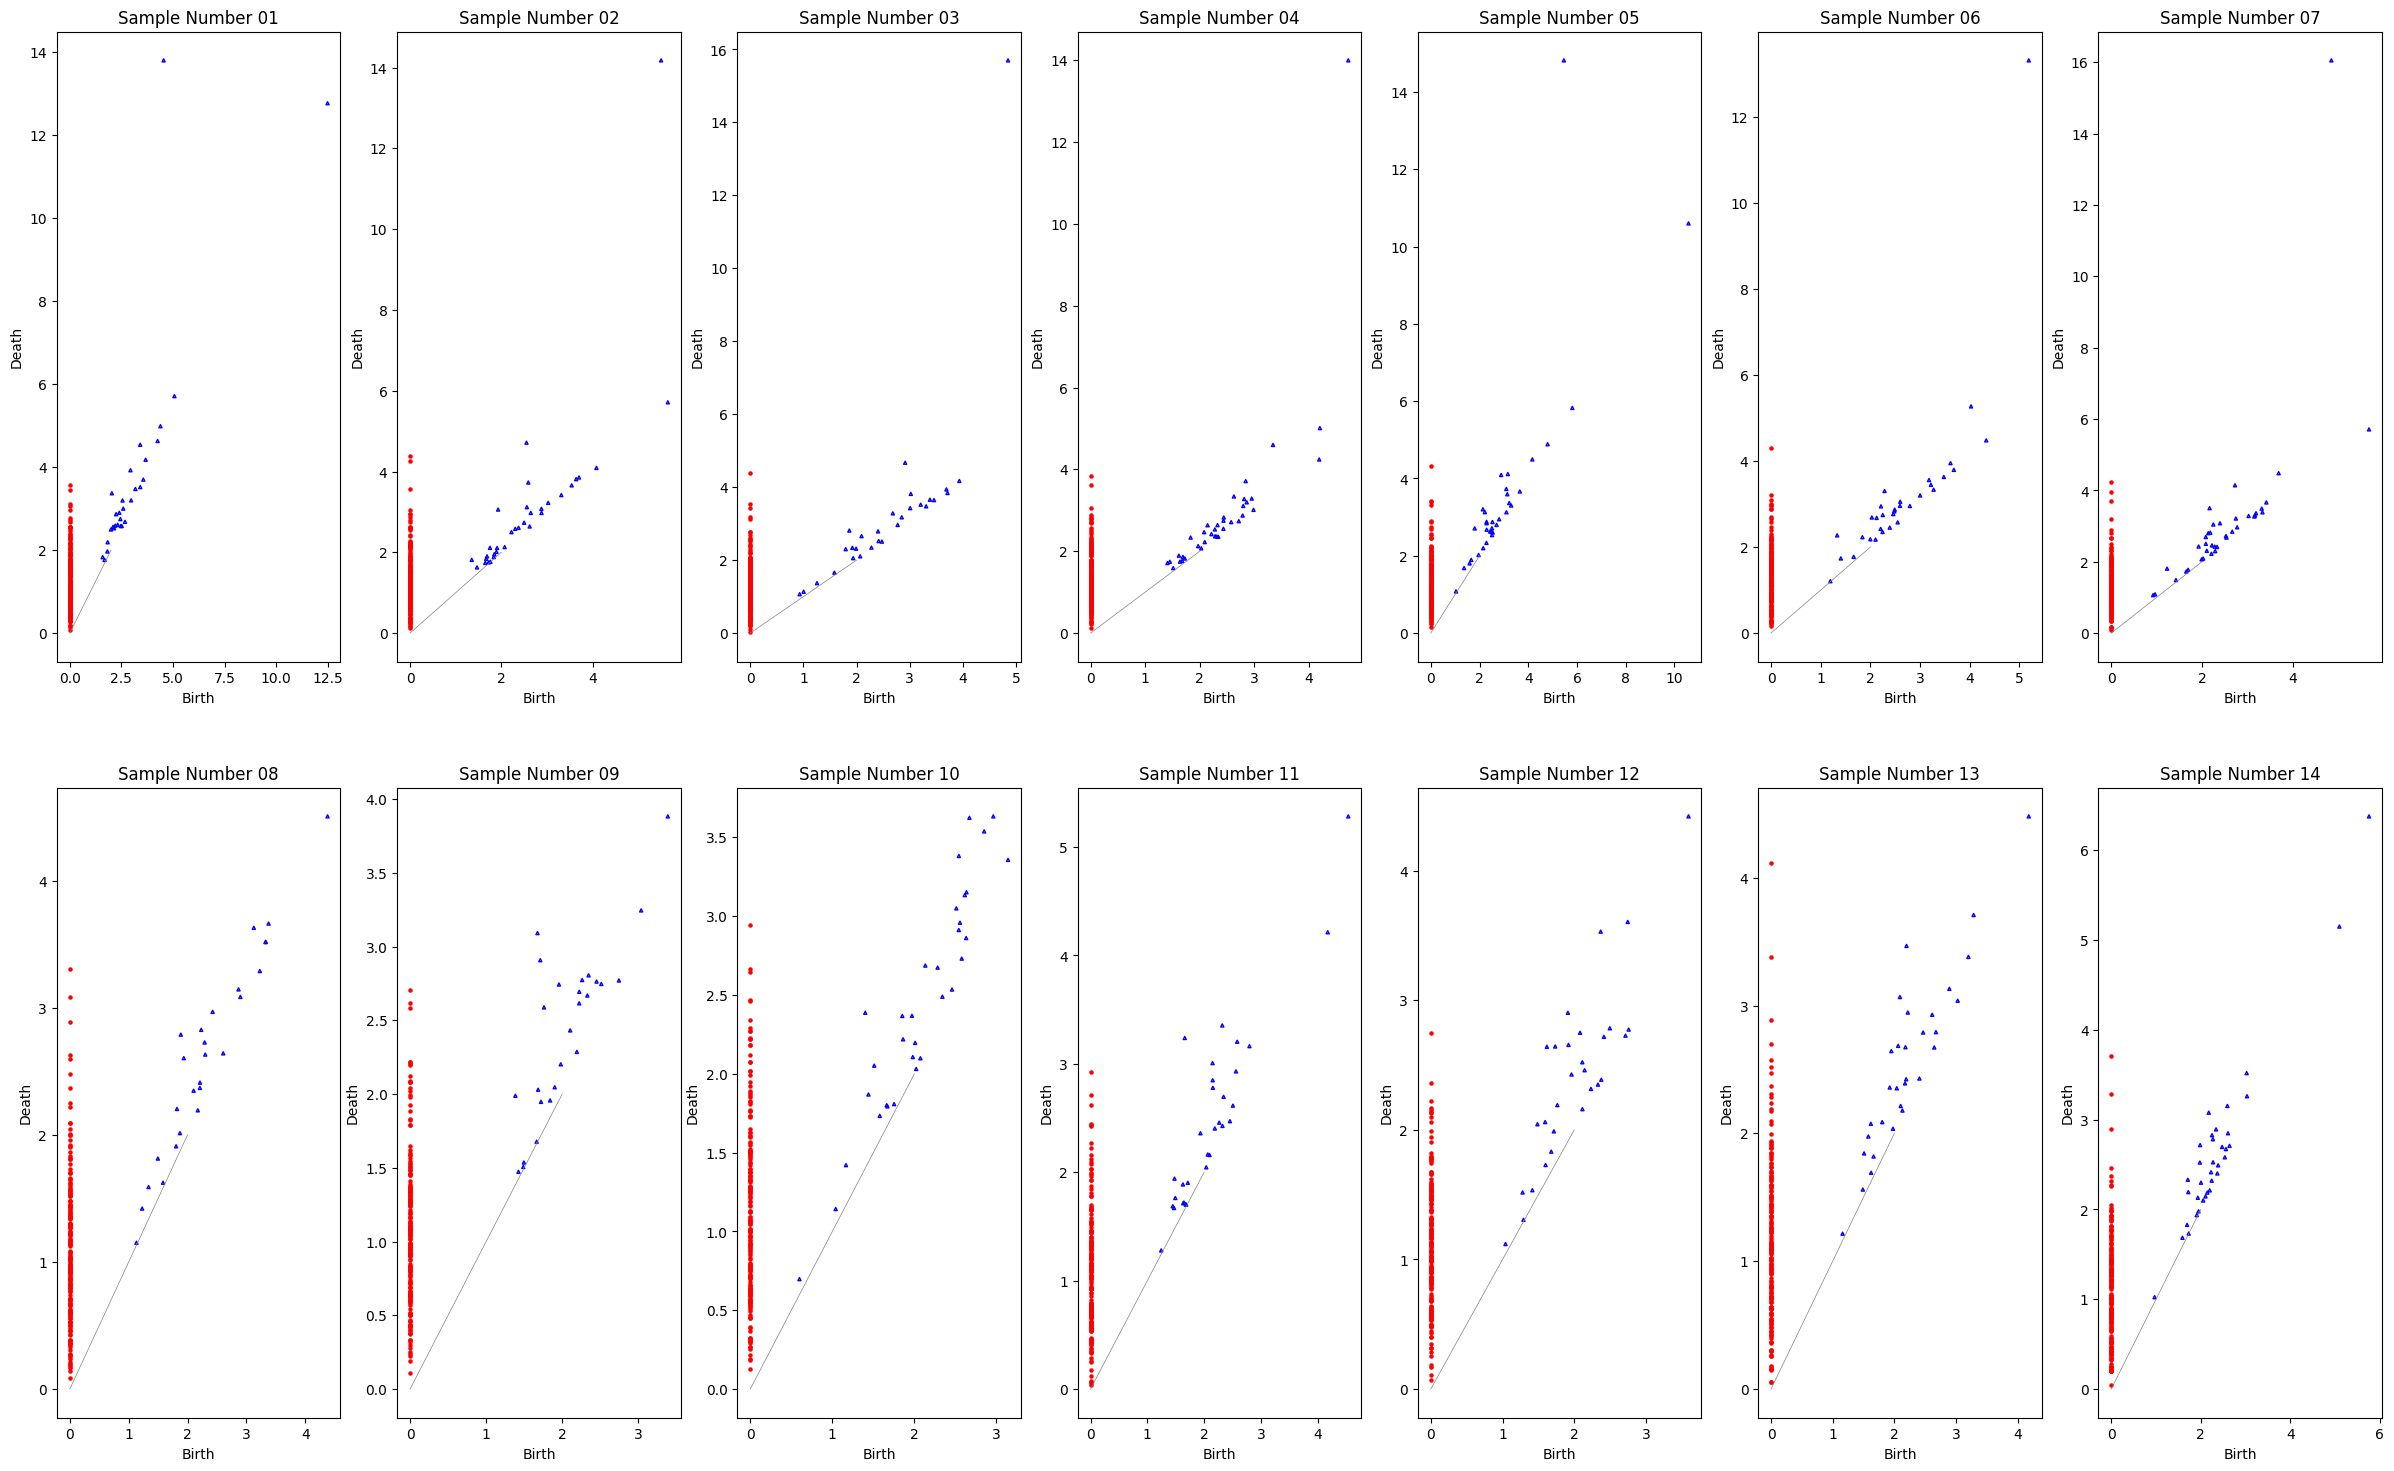

In [ ]:
titles = ['Sample Number %02d' %(i+1) for i in np.arange(n_clouds*2)]
plot_Dionysus_PDs(pd0_union, pd1_union, titles)

In [ ]:
wdist = np.zeros((n_clouds*2,n_clouds*2))
for i in range(n_clouds*2):
    xs= np.concatenate((pd0[i][0][:], pd1[i][0][:]), axis=0)
    ys= np.concatenate((pd0[i][1][:], pd1[i][1][:]), axis=0)
    Di = np.transpose([xs,ys])

    for j in range(i+1):
        #print(i,j)
        xs= np.concatenate((pd0[j][0][:], pd1[j][0][:]), axis=0)
        ys= np.concatenate((pd0[j][1][:], pd1[j][1][:]), axis=0)
        Dj = np.transpose([xs,ys])

        wdist[i,j] = wd(Di, Dj, order=2) #wasserstein(Di, Dj) # where the format of PD is numpy matrix
        wdist[j,i] = wdist[i,j]

wdist=(wdist-np.min(wdist))/(np.max(wdist)-np.min(wdist))

In [ ]:
wdist

array([[0.        , 0.30722926, 0.37309929, 0.1844684 , 0.27552408,
        0.26730751, 0.4035545 , 0.81067504, 0.89292566, 0.79840102,
        0.86345674, 0.90182608, 0.77898289, 0.80588855],
       [0.30722926, 0.        , 0.31999431, 0.28272999, 0.29280744,
        0.35286851, 0.36557195, 0.8364147 , 0.90249287, 0.83455387,
        0.8827182 , 0.91671355, 0.77728339, 0.82502825],
       [0.37309929, 0.31999431, 0.        , 0.35132723, 0.28536924,
        0.47149707, 0.24458703, 0.8932855 , 0.96504538, 0.89926141,
        0.9367076 , 0.97719002, 0.85697803, 0.89315738],
       [0.1844684 , 0.28272999, 0.35132723, 0.        , 0.26446501,
        0.24186554, 0.38706283, 0.83980628, 0.92753125, 0.81818157,
        0.89512984, 0.92073428, 0.80240349, 0.83002325],
       [0.27552408, 0.29280744, 0.28536924, 0.26446501, 0.        ,
        0.31217551, 0.26374696, 0.83088423, 0.9052626 , 0.83596501,
        0.8860417 , 0.90823828, 0.78828784, 0.82191653],
       [0.26730751, 0.35286851, 0.4

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(wdist)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

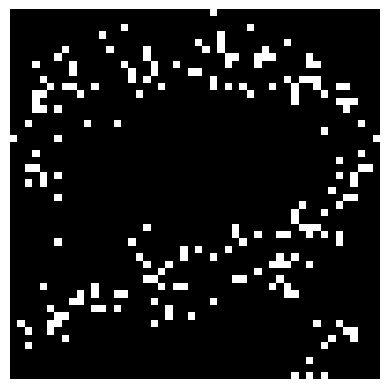

In [ ]:
binary_image1  = coordinates_to_image(samples[1][:, 0], samples[1][:, 1], image_size=(50, 50))
binary_image2  = coordinates_to_image(samples[2][:, 0], samples[2][:, 1], image_size=(50, 50))
plt.imshow(binary_image2, cmap='gray')
plt.axis('off')
plt.show()

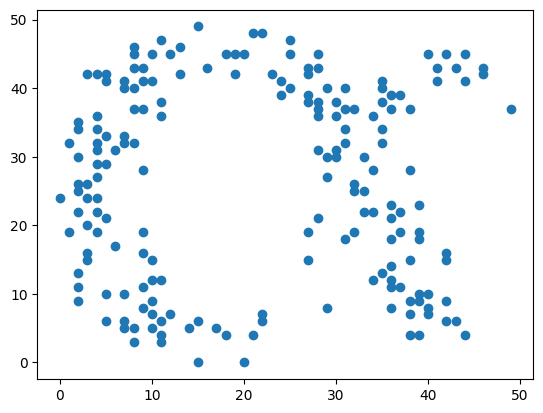

In [ ]:
pointcloud = np.argwhere(binary_image1 == 1)
plt.scatter(pointcloud[:, 0], pointcloud[:, 1])
plt.show()

In [ ]:
vectorList = []
for i in np.arange(n_clouds*2):
    temp = coordinates_to_image(samples[i][:, 0], samples[i][:, 1], image_size=(50, 50))
    vectorList.append(temp)

L2Dist = np.zeros((n_clouds*2,n_clouds*2))
for i in range(n_clouds*2):
    for j in range(i+1):
        L2Dist[i,j] = LA.norm(vectorList[i].reshape(1,2500)[0] - vectorList[j].reshape(1,2500)[0], 2)
        L2Dist[j,i] = L2Dist[i,j]

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(L2Dist)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)